<h1>Installing Dependencies<h1>


In [4]:
pip install tensorflow sklearn pandas numpy matplotlib nltk gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<h1>Setup</h1>

In [5]:
import os 
import io
import nltk
import string
import json
import random
import pandas as pd
import numpy as np
import gradio as gr
import matplotlib as mpl
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.callbacks import TensorBoard, EarlyStopping
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, SimpleRNN, BatchNormalization, LSTM, Dense, GlobalAveragePooling1D, Flatten, Dropout, GRU, Conv1D, MaxPool1D

<h1>Loading the dataset<h1>

In [6]:
with open("skincare_intents.json") as cerave_skincare_chatbot:
  dataset = json.load(cerave_skincare_chatbot)

<h1>Extracting Data from Dataset</h1>

In [7]:
#Extracting tags (intent), patterns (input provided by user) and responses (output provided by the bot) from dataset
def processing_json_dataset(dataset):
  tags = []
  patterns = []
  responses = {}
  for intent in dataset['intents']:
    responses[intent['tag']]=intent['responses']
    for lines in intent['patterns']:
      patterns.append(lines)
      tags.append(intent['tag'])
  return [tags, patterns, responses]

In [8]:
#Storing our extracted data
[tags, patterns, responses] = processing_json_dataset(dataset)

<h1>Conversion of Dataset into DataFrame</h1>

In [9]:
#Converting dataset into named columns patterns and tags respectively
dataset = pd.DataFrame({"patterns": patterns,
                     "tags": tags})

In [10]:
#Returning first five rows of dataset
dataset.head()

,patterns,tags
0,Hi there,greeting
1,How are you,greeting
2,Is anyone there?,greeting
3,Hey,greeting
4,Hi,greeting


In [11]:
#To return all rows in random order
dataset = dataset.sample(frac=1)

In [12]:
#Returning first five rows of dataset
dataset.head()

,patterns,tags
129,I've oily skin,oily_skin
54,My main concern is aging,concern-aging
8,Bye,goodbye
58,My main concern is Diabetic Skin,concern-diabetic-skin
126,not comfortable in sharing my age,age


<h1>Pre-processing text of dataset</h1>

In [13]:
#For each letter in pattern converting it to lowercase if it's not a special character
dataset['patterns'] = dataset['patterns'].apply(lambda sequence:
                                            [letters.lower() for letters in sequence if letters not in string.punctuation])

In [14]:
#Returning first five rows of dataset
dataset.head()

,patterns,tags
129,"[i, v, e, , o, i, l, y, , s, k, i, n]",oily_skin
54,"[m, y, , m, a, i, n, , c, o, n, c, e, r, n, ...",concern-aging
8,"[b, y, e]",goodbye
58,"[m, y, , m, a, i, n, , c, o, n, c, e, r, n, ...",concern-diabetic-skin
126,"[n, o, t, , c, o, m, f, o, r, t, a, b, l, e, ...",age


In [15]:
#Joining the lowercase letters into words again
dataset['patterns'] = dataset['patterns'].apply(lambda word: ''.join(word))

In [16]:
#Returning first five rows of dataset
dataset.head()

,patterns,tags
129,ive oily skin,oily_skin
54,my main concern is aging,concern-aging
8,bye,goodbye
58,my main concern is diabetic skin,concern-diabetic-skin
126,not comfortable in sharing my age,age


In [17]:
#The ids for most frequent 1000 words would be returned.
tokenizer = Tokenizer(num_words=1000)

#An index based vocabulary would be created based on the word frequency.
tokenizer.fit_on_texts(dataset['patterns'])

#It basically takes each word in the text and replaces it with its corresponding integer value from the vocabulary made in the previous step.
train = tokenizer.texts_to_sequences(dataset['patterns'])

#It will pad with 0 the shorter sequences to make sure all sequences have same length
features = pad_sequences(train)

#It takes a categorical column and converts/maps it to numerical values.
labelEncoder = LabelEncoder()
labels = labelEncoder.fit_transform(dataset['tags'])

In [18]:
#Checking shape of our patterns data
input_shape = features.shape[1]
features.shape

(147, 10)

In [19]:
#Calculating total unique words in dataset
vocabulary = len(tokenizer.word_index)
print("Number of unique words: ",vocabulary)
output_length = labelEncoder.classes_.shape[0]
print("Output length: ",output_length)

Number of unique words:  178
Output length:  52


In [20]:
#Checking our word vocabulary of most occuring words in pattern
tokenizer.word_index

{'products': 1,
 'skin': 2,
 'for': 3,
 'suggest': 4,
 'you': 5,
 'share': 6,
 'with': 7,
 'available': 8,
 'my': 9,
 'can': 10,
 'is': 11,
 'cerave': 12,
 'good': 13,
 'routine': 14,
 'dry': 15,
 'main': 16,
 'concern': 17,
 'oily': 18,
 'some': 19,
 'combination': 20,
 'body': 21,
 'ive': 22,
 'skincare': 23,
 'recommend': 24,
 'facial': 25,
 'any': 26,
 'serums': 27,
 'acne': 28,
 'baby': 29,
 'order': 30,
 '562b78': 31,
 'eye': 32,
 'moisturizers': 33,
 'thanks': 34,
 'me': 35,
 'sensitive': 36,
 'creams': 37,
 'how': 38,
 'acid': 39,
 'makeup': 40,
 'removers': 41,
 'tips': 42,
 'i': 43,
 'to': 44,
 'cleansers': 45,
 'aging': 46,
 'bye': 47,
 'psoriasis': 48,
 'where': 49,
 'id': 50,
 'are': 51,
 'bumpy': 52,
 'what': 53,
 'help': 54,
 'and': 55,
 'allergies': 56,
 'itchy': 57,
 'rough': 58,
 'about': 59,
 'new': 60,
 'hi': 61,
 'there': 62,
 'cracked': 63,
 'irritated': 64,
 'helpful': 65,
 'sunscreens': 66,
 'combo': 67,
 'reduce': 68,
 'eczema': 69,
 'diabetic': 70,
 'not': 71,

<h1>Model training and evaluation</h1>

In [38]:
#Creating a linear stack of layers.
model = Sequential()

#Letting the model know about the shape of input it will be receiving
model.add(Input(shape=(input_shape)))

#This layer will enable us to convert each word into a fixed length vector of defined size in this case 100
model.add(Embedding(vocabulary+1, 100))

#Adding dropout to randomly set inputs to 0 out of all scalars inputs with a rate of 0.3.
model.add(Dropout(0.3))

#SimpleRNN layer which is a fully-connected RNN where the output is to be fed back to input
model.add(SimpleRNN(16, return_sequences=False))

#Applying batch normalization to maintain the mean output close to 0 and the output standard deviation close to 1
model.add(BatchNormalization())

#Fully-connected layer with relu activation and l2 regularizer to apply penalties on layer parameters
model.add(Dense(128,activation="relu", activity_regularizer = tf.keras.regularizers.L2(0.0001))) 

#Softmax output layer to normalize the output of a network to a probability distribution over predicted output classes
model.add(Dense(output_length, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))

In [22]:
#Getting details about model layers
model.layers

In [23]:
#GloVe is an unsupervised learning algorithm for obtaining vector representations for words. 
#Training is performed on aggregated global word-word co-occurrence statistics from a corpus, 
#and the resulting representations showcase interesting linear substructures of the word vector space.
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-01-07 13:17:52--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-07 13:17:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 41s  

2023-01-07 13:20:33 (5.11 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [24]:
#Getting glove file and returning the total number of word vectors available 
glove_dir = "glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir)
for line in file_:
    arr = line.split()
    single_word = arr[0]
    word = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = word
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [25]:
#Creating embedding matrix to assign weights to the embedding layer
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,100)).astype(object)
for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [26]:
#Setting weights of embedding layer and specifying it as non-trainable
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [42]:
#Compiling the model by specifying loss as sparse_categorical_crossentropy and optimizer as adam
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [28]:
#Accessing model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           17900     
                                                                 
 dropout (Dropout)           (None, 10, 100)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                1872      
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               2176      
                                                                 
 dense_1 (Dense)             (None, 52)                6708      
                                                        

In [41]:
#This callback will stop the training when there is no improvement in the loss for forty consecutive epochs.
earlyStopping = EarlyStopping(monitor = 'loss', patience = 400, mode = 'min', restore_best_weights = True)

In [47]:
#Train for 2000 epochs with batch size of 64.
history_training = model.fit(features, labels, epochs=2000, batch_size=64)
model.save('cerave_skincare_model.h5', history_training)

Epoch 1/2000
3/3 [==============================] - 0s 9ms/step - loss: 0.0150 - accuracy: 0.9932
Epoch 2/2000
3/3 [==============================] - 0s 8ms/step - loss: 0.0147 - accuracy: 0.9932
Epoch 3/2000
3/3 [==============================] - 0s 8ms/step - loss: 0.0159 - accuracy: 0.9864
Epoch 4/2000
3/3 [==============================] - 0s 8ms/step - loss: 0.0159 - accuracy: 0.9932
Epoch 5/2000
3/3 [==============================] - 0s 8ms/step - loss: 0.0143 - accuracy: 1.0000
Epoch 6/2000
3/3 [==============================] - 0s 8ms/step - loss: 0.0142 - accuracy: 1.0000
Epoch 7/2000
3/3 [==============================] - 0s 8ms/step - loss: 0.0143 - accuracy: 0.9932
Epoch 8/2000
3/3 [==============================] - 0s 7ms/step - loss: 0.0163 - accuracy: 0.9932
Epoch 9/2000
3/3 [==============================] - 0s 7ms/step - loss: 0.0158 - accuracy: 0.9932
Epoch 10/2000
3/3 [==============================] - 0s 7ms/step - loss: 0.0155 - accuracy: 0.9932
Epoch 11/2000
3/3 [

In [31]:
#Function to plot graphs of training data performance
def draw_plot(data, type_data):
  mpl.style.use('seaborn')
  plt.figure(figsize = (25, 5))
  plt.plot(data,'#005EA2', label='Train')
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()

<h1>Loss on training set</h1>

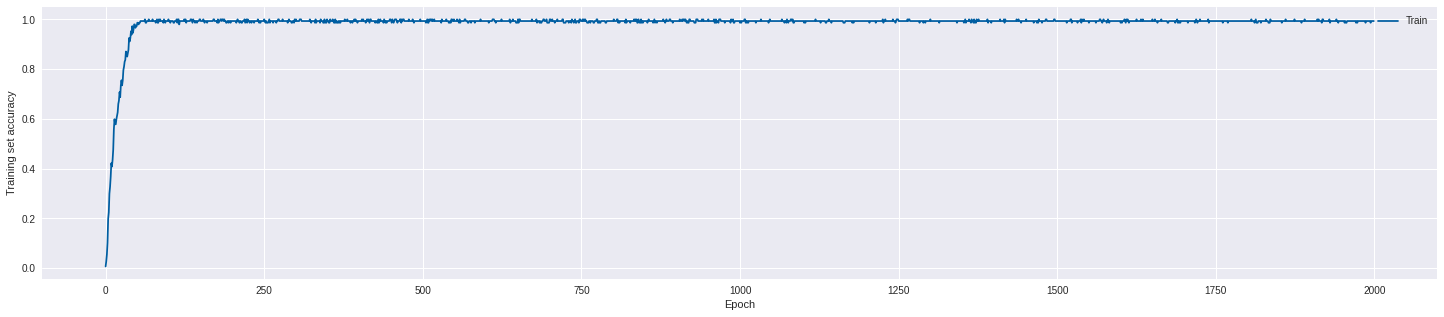

In [44]:
draw_plot(history_training.history['accuracy'],'Training set accuracy')

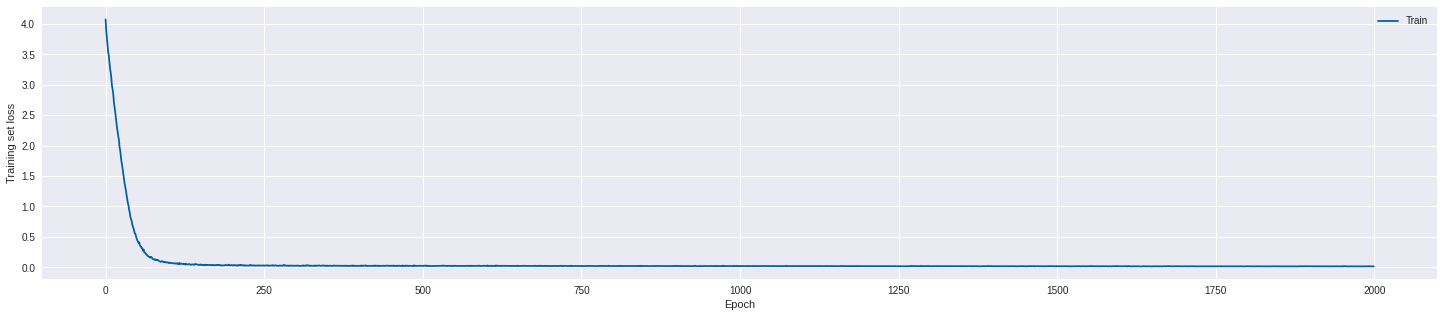

In [45]:
draw_plot(history_training.history['loss'],'Training set loss')

<h1>Evaluating the model</h1>

In [34]:
model.evaluate(features, labels)

5/5 [==============================] - 0s 4ms/step - loss: 0.0507 - accuracy: 0.9796


[0.05068876966834068, 0.9795918464660645]

In [35]:
print(f"Final loss: {history_training.history['loss'][-1]}")

Final loss: 0.06594838947057724


<h1>Testing the model</h1>

In [36]:
#To store messages for session
history = []
def generate_response(query):
  texts = []

  #Processing user input
  user_input = query
  user_input = [letters.lower() for letters in user_input if letters not in string.punctuation]
  user_input = ''.join(user_input)
  texts.append(user_input)
  user_input = tokenizer.texts_to_sequences(texts)
  user_input = np.array(user_input).reshape(-1)
  user_input = pad_sequences([user_input],input_shape)

  #Predicting the results
  output = model.predict(user_input)

  #Returning the indices of maximum value
  output = output.argmax()

  #Transforming back to original data from numerical values
  response_tag = labelEncoder.inverse_transform([output])[0]

  #Appending user query with bots reply to render in UI
  history.append((query, random.choice(responses[response_tag])))
  return history

<h1>Chatbot UI using Gradio<h1>

In [46]:
#Creating a gradio block to render UI for chatbot
with gr.Blocks(title= 'Cerave Skincare Chatbot', css='gradio.css') as demo:
    gr.Markdown("<h1>Cerave Skincare Chatbot</h1>")
    output = gr.outputs.Chatbot()

    #Gradio row for user input and ask button
    with gr.Row():
      input = gr.inputs.Textbox(placeholder="Ask me anything")
      ask_button = gr.Button("Ask")
    
    #Calling generate response and clearing user input textbox
    ask_button.click(fn=generate_response, inputs=input, outputs=output)
    ask_button.click(lambda x: "", input, input)

demo.launch()  

/usr/local/lib/python3.8/dist-packages/gradio/outputs.py:309: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>